## Checklist de Entrega

- Acurácia calculada e interpretada
- Matriz de confusão gerada
- Fronteira de decisão visualizada
- Análise crítica completa (escalabilidade, ruído, ansatz)
- Conclusões honestas sobre limitações
- Discussão sobre vantagem quântica


## Importação de Bibliotecas

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

## 4.1 Carregar Dados e Modelo

In [2]:
# Carregar dados de teste
X_train = np.load('../data/X_train.npy')
X_test = np.load('../data/X_test.npy')
y_train = np.load('../data/y_train.npy')
y_test = np.load('../data/y_test.npy')

# Converter para {-1, +1}
y_test_quantum = 2 * y_test - 1

# Carregar parâmetros treinados
trained_params = np.load('../results/trained_params.npy')
loss_history = np.load('../results/loss_history.npy')

## 4.2 Re-criar QNode para Inferência

In [3]:
# Re-criar (re-instanciar) device e circuit treinado e prepará-lo especificamente para a fase de teste e avaliação
n_qubits = 2
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(params, x):
    qml.RX(x, wires=0)
    qml.RY(params, wires=0)
    return qml.expval(qml.PauliZ(0))

def predict(params, x):
    return np.sign(quantum_circuit(params, x))

## 4.3 Acurácia no Conjunto de Teste

In [4]:
# 3. Funções Auxiliares
def preprocess_x(x):
    # Garante que x seja um escalar (média, soma, ou pegar o primeiro elemento)
    return float(np.mean(x))

def predict(params, x):
    x_scalar = preprocess_x(x)
    
    # Extrai o valor escalar dos parâmetros treinados
    # Se params for um array, pega o primeiro item. Se for float, mantém.
    param_scalar = float(np.ravel(params)[0]) if np.ndim(params) > 0 else float(params)
    
    # Passa os escalares para o circuito
    result = quantum_circuit(param_scalar, x_scalar)
    return np.sign(result)

# 4. Execução (Assumindo que X_test, y_test_quantum e trained_params existem)
# Exemplo fictício para teste se você não tiver os dados carregados agora:
# X_test = [np.array([0.1, 0.2]), np.array([0.5, -0.1])]
# trained_params = np.array([0.15])
# y_test_quantum = [1, -1]

try:
    y_pred = np.array([predict(trained_params, x) for x in X_test])
    
    # Calcular acurácia
    accuracy = accuracy_score(y_test_quantum, y_pred)
    print(f"Test Accuracy: {accuracy:.2%}")

except Exception as e:
    print(f"Erro ainda persistente: {e}")

Test Accuracy: 66.67%


### Interpretação da Acurácia

<!-- TODO: Analisar resultado -->
<!-- - É boa para um modelo com 2 qubits? -->
<!-- - Comparar com baseline (50%) -->
<!-- - Overfitting? Underfitting? -->

## 4.4 Matriz de Confusão

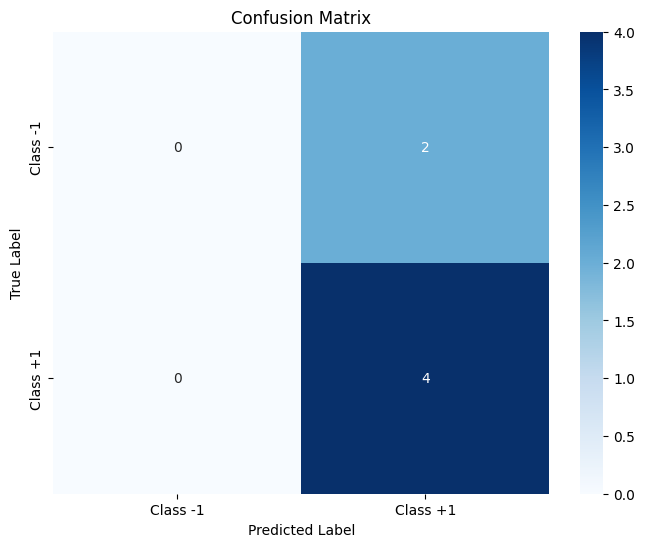

              precision    recall  f1-score   support

    Class -1       0.00      0.00      0.00         2
    Class +1       0.67      1.00      0.80         4

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [5]:
# Gerar matriz de confusão
cm = confusion_matrix(y_test_quantum, y_pred)

# Visualizar
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
             xticklabels=['Class -1', 'Class +1'],
             yticklabels=['Class -1', 'Class +1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test_quantum, y_pred, 
                            target_names=['Class -1', 'Class +1']))

## 4.5 Fronteira de Decisão

Visualização mais importante do bloco.

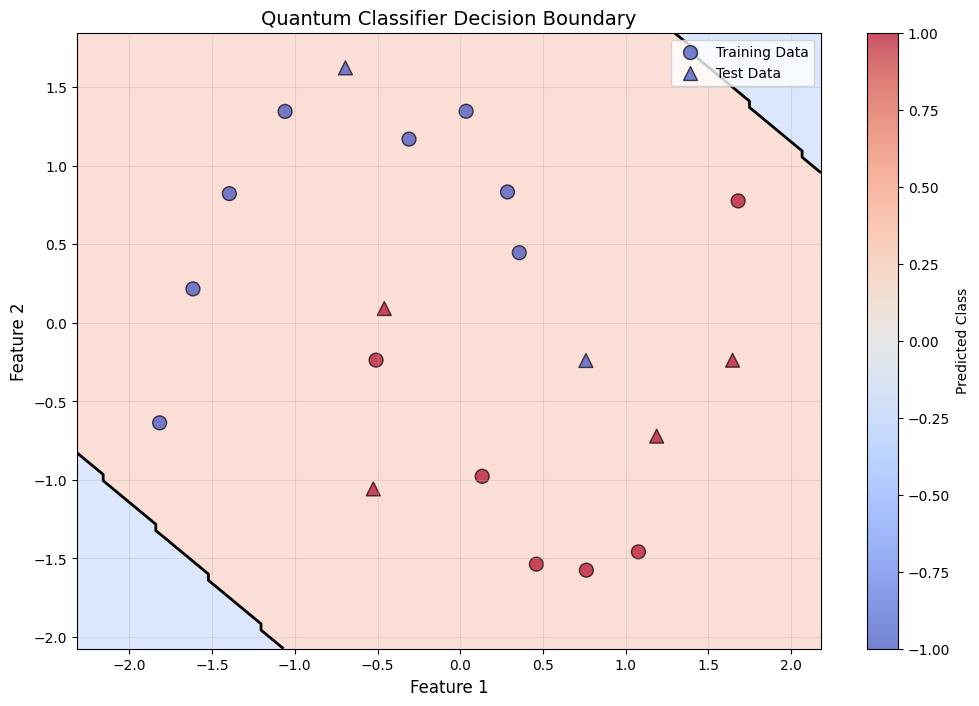

In [6]:
# Criar grid de pontos
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                      np.linspace(y_min, y_max, 100))

# Fazer previsões no grid
Z = np.array([predict(trained_params, np.array([x, y])) 
               for x, y in zip(xx.ravel(), yy.ravel())])
Z = Z.reshape(xx.shape)

# Plotar fronteira
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm', levels=[-1, 0, 1])
plt.contour(xx, yy, Z, colors='black', linewidths=2, levels=[0])

# Plot training data
plt.scatter(X_train[:, 0], X_train[:, 1], 
            c=(2*y_train - 1), cmap='coolwarm', 
            edgecolors='k', s=100, alpha=0.7, label='Training Data')

# Plot test data
plt.scatter(X_test[:, 0], X_test[:, 1], 
            c=(2*y_test - 1), cmap='coolwarm', 
            edgecolors='k', s=100, marker='^', alpha=0.7, label='Test Data')

plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Quantum Classifier Decision Boundary', fontsize=14)
plt.legend()
plt.colorbar(label='Predicted Class')
plt.grid(True, alpha=0.3)
plt.show()

---
### Análise da Fronteira

<!-- TODO: Analisar visualmente -->
<!-- - A fronteira captura a não-linearidade? -->
<!-- - Onde o modelo acerta? -->
<!-- - Onde o modelo erra? -->
<!-- - Overfitting visual? -->

## 4.6 Análise Crítica: Limitações

### 4.6.1 Escalabilidade

<!-- TODO: Discutir problemas de escala -->

**Limitações:**
- Apenas 2 qubits (2 features)
- Datasets reais têm centenas/milhares de features
- Cada feature adicional = mais qubits
- Hardware atual: ~100 qubits ruidosos

**Impacto:**
- Não escala para problemas reais
- Embedding é o gargalo principal
### 4.6.2 Ruído Quântico

<!-- TODO: Discutir impacto do ruído -->

**Problema:**
- Simulador é perfeito (sem ruído)
- Hardware real: erros em gates, decoerência, ruído de medição

**Consequência:**
- Modelo não funcionaria em hardware atual (NISQ)
- Precisaria de técnicas de mitigação de erro
- Error correction está longe de ser prático
### 4.6.3 Sensibilidade ao Ansatz

<!-- TODO: Discutir design do circuito -->

**Observações:**
- Performance depende fortemente do ansatz escolhido
- Não há teoria geral para design de ansatz
- Trial-and-error é necessário
- Barren plateaus limitam profundidade
### 4.6.4 Vantagem Quântica?

<!-- TODO: Ser honesto sobre vantagens -->

**Realidade:**
- Para make_moons: SVM clássico é melhor
- Modelo quântico: mais lento, menos acurado
- Vantagem quântica não demonstrada para ML supervisionado

**Perspectiva futura:**
- Pode haver vantagens para problemas específicos
- Requer hardware fault-tolerant
- Pesquisa ativa, mas sem garantias

---
## 4.7 Conclusões Finais
### O que aprendemos:

✅ **Funcionou:**
- VQC consegue aprender problemas não-lineares simples
- Parameter-shift permite calcular gradientes quânticos
- Framework é matematicamente sólido

❌ **Limitações práticas:**
- Não escala para problemas reais
- Ruído impede uso em hardware atual
- Nenhuma vantagem demonstrada vs. ML clássico

🔬 **Valor científico:**
- Exploração de algoritmos quânticos
- Compreensão de limites atuais
- Base para pesquisa futura